# Data Creation

In [1]:
import numpy as np
import os

In [2]:
N = 100

In [3]:
s = np.random.uniform(0,1,N)

In [4]:
import networkx as nx
import torch

In [5]:
intervals = [1/4, 2/4, 3/4, 1]
sizes = []
for i in range(0, len(intervals)):
    size = 0
    for j in range(0, len(s)):
        if i == 0:
            if s[j] > 0 and s[j] <= intervals[0]:
                size = size + 1
        elif s[j] > intervals[i-1] and s[j] <= intervals[i]:
            size = size+1
    sizes.append(size)

In [6]:
sizes

[25, 32, 21, 22]

In [7]:
ss = torch.tensor(s).reshape(N,1)

In [8]:
probsPerInt = [6/16, 1/16, 2/16, 3/16]

In [9]:
probs = []
for i in range(0, len(probsPerInt)):
    prob = [1/16] * len(probsPerInt)
    prob[i] = probsPerInt[i]
    print(prob)
    probs.append(prob)

[0.375, 0.0625, 0.0625, 0.0625]
[0.0625, 0.0625, 0.0625, 0.0625]
[0.0625, 0.0625, 0.125, 0.0625]
[0.0625, 0.0625, 0.0625, 0.1875]


In [10]:
g = nx.stochastic_block_model(sizes, probs, seed=0)

# Model Creation

In [11]:
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import InnerProductDecoder
from torch_geometric.nn import GAE

In [12]:
from torch_geometric.utils import from_networkx    

In [13]:
graph = from_networkx(g)

In [14]:
from torch_geometric.utils import degree

d = degree(graph.edge_index[0], N, dtype=torch.long).reshape(N,1)

graph.x = ss
#graph.x = graph.x.type(torch.LongTensor)
graph.x = graph.x.type(torch.FloatTensor)

In [15]:
graph.x = d/N
#graph.x = graph.x.type(torch.LongTensor)
graph.x = graph.x.type(torch.FloatTensor)
graph.pos = ss.type(torch.FloatTensor)

In [16]:
torch.save(graph, 
                os.path.join('../input', 
                    f'RGG_100nodes.pt'))

In [17]:
gS = SAGEConv(graph.num_node_features, 2, root_weight=False, bias=False)

In [18]:
torch.save(gS.state_dict(), '../models/GraphSage')

gS = SAGEConv()
gS.load_state_dict(torch.load( '../models/GCNTwoLayersGraphSage'))

In [19]:
message = gS(graph.x, graph.edge_index)

In [20]:
messagenp = message.cpu().detach().numpy()

In [21]:
import matplotlib.pyplot as plt

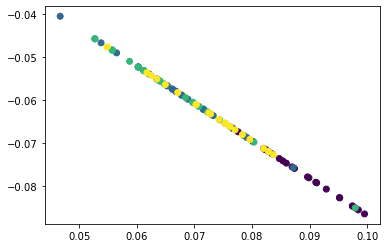

In [22]:
x = messagenp[:,0]
y = messagenp[:,1]
colors = graph.block

plt.scatter(x, y, c=colors, cmap='viridis')

plt.show() 

In [23]:
IPD = InnerProductDecoder()

In [24]:
GAESage = GAE(gS, IPD)

# Training

In [26]:
model = GAESage

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [28]:
from torch_geometric.utils import train_test_split_edges
data = train_test_split_edges(graph)

/home/math/maskey/anaconda3/envs/pyg_cuda102/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [29]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(graph.x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    #if args.variational:
    #   loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    print(loss)
    return float(loss)

In [30]:
def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(graph.x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

In [31]:
train_pos_edge_index = data.train_pos_edge_index

In [32]:
for epoch in range(1, 101):
    loss = train()

    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

tensor(1.3861, grad_fn=<AddBackward0>)
Epoch: 001, AUC: 0.6198, AP: 0.6823
tensor(1.3861, grad_fn=<AddBackward0>)
Epoch: 002, AUC: 0.6198, AP: 0.6823
tensor(1.3861, grad_fn=<AddBackward0>)
Epoch: 003, AUC: 0.6198, AP: 0.6823
tensor(1.3861, grad_fn=<AddBackward0>)
Epoch: 004, AUC: 0.6198, AP: 0.6823
tensor(1.3861, grad_fn=<AddBackward0>)
Epoch: 005, AUC: 0.6198, AP: 0.6823
tensor(1.3861, grad_fn=<AddBackward0>)
Epoch: 006, AUC: 0.6198, AP: 0.6823
tensor(1.3861, grad_fn=<AddBackward0>)
Epoch: 007, AUC: 0.6198, AP: 0.6823
tensor(1.3861, grad_fn=<AddBackward0>)
Epoch: 008, AUC: 0.6198, AP: 0.6823
tensor(1.3861, grad_fn=<AddBackward0>)
Epoch: 009, AUC: 0.6198, AP: 0.6823
tensor(1.3861, grad_fn=<AddBackward0>)
Epoch: 010, AUC: 0.6198, AP: 0.6823
tensor(1.3861, grad_fn=<AddBackward0>)
Epoch: 011, AUC: 0.6198, AP: 0.6823
tensor(1.3861, grad_fn=<AddBackward0>)
Epoch: 012, AUC: 0.6198, AP: 0.6823
tensor(1.3860, grad_fn=<AddBackward0>)
Epoch: 013, AUC: 0.6198, AP: 0.6823
tensor(1.3860, grad_fn=<A

In [43]:
torch.save(GAESage.state_dict(), '../models/GraphSage')

In [33]:
class GCN(torch.nn.Module):
    def __init__(self):
        #super().__init__()
        super(GCN, self).__init__()
        self.lin1 = torch.nn.Linear(1, 4)
        self.lin2 = torch.nn.Linear(4, 1)
        self.graphSage = SAGEConv(data.num_node_features, 2, root_weight=False, bias=False)

        #self.graphSage = SAGEConv(DL.get(101).num_node_features,1 ,root_weight = False, bias = False)
        
    def forward(self, x, edge_index):
        print(edge_index.type())
        x, edge_index = x, edge_index

        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        #x = F.dropout(x, training=self.training)
        x = self.graphSage(x, edge_index)

        return x
        #F.log_softmax(x, dim=1)

In [34]:
model = GAE(GCN())

In [35]:
import torch.nn.functional as F

In [36]:
for epoch in range(1, 101):
    loss = train()

    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

torch.LongTensor
tensor(1.3868, grad_fn=<AddBackward0>)
torch.LongTensor
Epoch: 001, AUC: 0.3770, AP: 0.4934
torch.LongTensor
tensor(1.3868, grad_fn=<AddBackward0>)
torch.LongTensor
Epoch: 002, AUC: 0.3770, AP: 0.4934
torch.LongTensor
tensor(1.3868, grad_fn=<AddBackward0>)
torch.LongTensor
Epoch: 003, AUC: 0.3770, AP: 0.4934
torch.LongTensor
tensor(1.3868, grad_fn=<AddBackward0>)
torch.LongTensor
Epoch: 004, AUC: 0.3770, AP: 0.4934
torch.LongTensor
tensor(1.3868, grad_fn=<AddBackward0>)
torch.LongTensor
Epoch: 005, AUC: 0.3770, AP: 0.4934
torch.LongTensor
tensor(1.3868, grad_fn=<AddBackward0>)
torch.LongTensor
Epoch: 006, AUC: 0.3770, AP: 0.4934
torch.LongTensor
tensor(1.3868, grad_fn=<AddBackward0>)
torch.LongTensor
Epoch: 007, AUC: 0.3770, AP: 0.4934
torch.LongTensor
tensor(1.3868, grad_fn=<AddBackward0>)
torch.LongTensor
Epoch: 008, AUC: 0.3770, AP: 0.4934
torch.LongTensor
tensor(1.3868, grad_fn=<AddBackward0>)
torch.LongTensor
Epoch: 009, AUC: 0.3770, AP: 0.4934
torch.LongTensor
te

tensor(1.3868, grad_fn=<AddBackward0>)
torch.LongTensor
Epoch: 089, AUC: 0.3770, AP: 0.4934
torch.LongTensor
tensor(1.3868, grad_fn=<AddBackward0>)
torch.LongTensor
Epoch: 090, AUC: 0.3770, AP: 0.4934
torch.LongTensor
tensor(1.3868, grad_fn=<AddBackward0>)
torch.LongTensor
Epoch: 091, AUC: 0.3770, AP: 0.4934
torch.LongTensor
tensor(1.3868, grad_fn=<AddBackward0>)
torch.LongTensor
Epoch: 092, AUC: 0.3770, AP: 0.4934
torch.LongTensor
tensor(1.3868, grad_fn=<AddBackward0>)
torch.LongTensor
Epoch: 093, AUC: 0.3770, AP: 0.4934
torch.LongTensor
tensor(1.3868, grad_fn=<AddBackward0>)
torch.LongTensor
Epoch: 094, AUC: 0.3770, AP: 0.4934
torch.LongTensor
tensor(1.3868, grad_fn=<AddBackward0>)
torch.LongTensor
Epoch: 095, AUC: 0.3770, AP: 0.4934
torch.LongTensor
tensor(1.3868, grad_fn=<AddBackward0>)
torch.LongTensor
Epoch: 096, AUC: 0.3770, AP: 0.4934
torch.LongTensor
tensor(1.3868, grad_fn=<AddBackward0>)
torch.LongTensor
Epoch: 097, AUC: 0.3770, AP: 0.4934
torch.LongTensor
tensor(1.3868, grad

In [38]:
Z = model.encode(graph.x, train_pos_edge_index)

torch.LongTensor


In [39]:
Z = Z.detach().numpy()

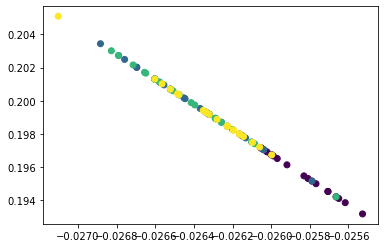

In [41]:
x = Z[:,0]
y = Z[:,1]
colors = graph.block

plt.scatter(x, y, c=colors, cmap='viridis')

plt.show() 

In [42]:
model = GAE(GCN())
model.load_state_dict(torch.load( '../models/GCNTwoLayersGraphSage'))

<All keys matched successfully>